In [ ]:
# Python Script
# Calibration of the diffraction projection
# from a diffraction pattern of a known crystal
#
# by J. Barthel / Forschungszentrum Jülich GmbH, Jülich, Germany
# email: ju.barthel@fz-juelich.de
#
# part of the emilys project: https://github.com/ju-bar/emilys
# published under the GNU GPL 3.0 License
#
# - record with as parallel illumination as possible
# - avoid recording noisy data (make long exposures)
# - avoid over saturation of the detector
# - avoid strong diffraction defocus or astigmatism

In [1]:
import numpy as np
import emilys.image.arrayplot as aplt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from emilys.numerics.mc import mc_image_pos_maximize
from emilys.image.imagedata import image_pos_sum

In [2]:
sworkdir = '../data/' # ! Set working directory !
ldat0 = np.fromfile(sworkdir + 'dif_cal_avg.dat', dtype='float64') # load the image data

<IPython.core.display.Javascript object>


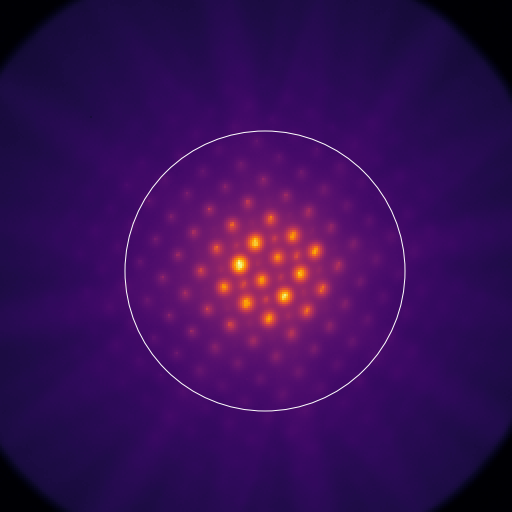

In [3]:
ndim = np.array([256,256]) # ! Set image dimension !
pcenter = np.array([132.,120.]) # ! Set center of peak search area !
prange = 70. # ! Set range of peak search area !
limg0 = ldat0.reshape(ndim) # get the image in shape
%matplotlib notebook
plot0 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image and enhance low at low intensities
prangecircle = Circle(pcenter, prange, color='w', fill=False)
ax = plt.gca()
ax.add_patch(prangecircle)

In [4]:
# try locating local minima using a Monte-Carlo
# - determine the intensity variations for pixels close to the range circle defined above
sr1 = 0.
sr2 = 0.
srn = 0
si = 0.
for j in range(0,ndim[0]):
    for i in range(0,ndim[1]):
        if np.abs(np.sqrt((i-pcenter[0])**2 + (j-pcenter[1])**2) - prange) < 1.:
            si = limg0[j,i]
            sr1 += si
            sr2 += si**2
            srn += 1
rmean = sr1 / srn
rsdev = np.sqrt(sr2 / srn - rmean*rmean)
print('- intensity on range limit (mean, sdev):',[rmean,rsdev])
# initialize a list of points (one for each pixel in the range)
lrpt = np.array([])
nrpt = 0
for j in range(0,ndim[0]):
    for i in range(0,ndim[1]):
        if np.sqrt((i - pcenter[0])**2 + (j - pcenter[1])**2) < prange:
            if nrpt == 0:
                lrpt = np.array([[1.*j,1.*i]])
            else:
                lrpt = np.concatenate((lrpt,np.array([[1.*j,1.*i]])))
            nrpt += 1
print('- test points for peak finding:', lrpt.shape[0])

- intensity on range limit (mean, sdev): [1.2812710840373993, 0.20246023620516143]
- test points for peak finding: 15361


In [19]:
# repeat until iterations < 100
s0 = image_pos_sum(limg0, lrpt)
nit = mc_image_pos_maximize(limg0, lrpt, 0.1, rsdev/1000, 100)
s1 = image_pos_sum(limg0, lrpt)
print('- initial:', s0, ', final:', s1, ', iterations:', nit)

- initial: 398155.9878353 , final: 398155.9878353 , iterations: 1


<IPython.core.display.Javascript object>


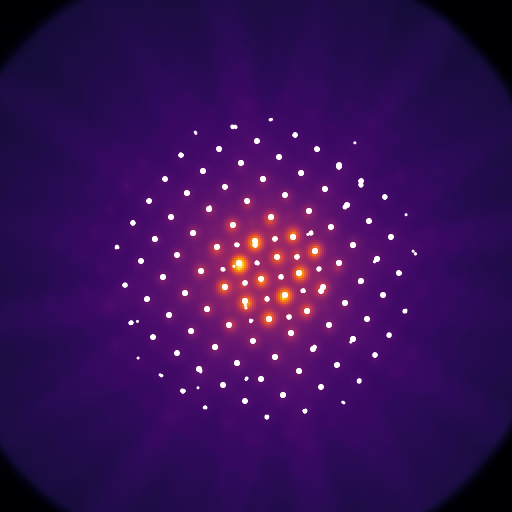

In [20]:
plot1 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
ax = plt.gca()
for l in range(0,lrpt.shape[0]):
    prangecircle = Circle(np.flip(lrpt[l]), 0.5, color='w', fill=True)
    ax.add_patch(prangecircle)